In [61]:
import os
import gc
import time
import matplotlib.pyplot as plt
import numpy as np

from pandas import read_csv
from obspy import UTCDateTime
from datetime import datetime

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Load Data

In [145]:
config = {}

config['dates'] = ["20240701", "20240705", "20240708", "20240710", "20240712", "20240715", "20240717", "20240722", "20240724"]

# 2024-07-08 -> errors
# 2024-07-22 -> errors
config['errors'] = ["20240708", "20240722"]

config['dates'] = [_d for _d in config['dates'] if _d not in config['errors']]

config['path_to_data'] = data_path+"ROMY_geoelectric/data/"

config['path_to_figs'] = data_path+"ROMY_geoelectric/figures/"

t1, t2 = UTCDateTime(min(config['dates']))-2*86400, UTCDateTime(max(config['dates']))+86400


In [146]:
ctimes = np.zeros([len(config['dates'])])
for i, d in enumerate(config['dates']):
    file = f"ROMY_{d}.slm"
    ctime = os.path.getmtime(config['path_to_data']+file)
    print(UTCDateTime(datetime.fromtimestamp(ctime)))
    ctimes[i] = UTCDateTime(datetime.fromtimestamp(ctime)) - t1

2024-07-01T16:23:48.000000Z
2024-07-05T12:10:52.000000Z
2024-07-10T14:17:04.000000Z
2024-07-12T14:25:30.000000Z
2024-07-15T16:14:16.000000Z
2024-07-17T14:45:26.000000Z
2024-07-24T11:46:46.000000Z


In [147]:
header = ["channel", "spacing_m", "layer", "R_ohmm", "I_mA", "U_muV", "XX"]

dfs = []
for date in config['dates']:

    df0 = read_csv(config['path_to_data']+f"ROMY_{date}.csv", names=header)

    dfs.append(df0)


In [148]:
def __get_image(df0, value="SD"):
    max_layer = int(df0.layer.max())
    min_channel = int(df0.channel.min())
    max_channel = int(df0.channel.max())

    # image dummy
    img = np.ones((max_layer, max_channel))*np.nan

    # offset of layers to form triangle
    off = 0

    # loop over layers and channels
    for l in range(1, max_layer+1):
        for c in range(1, max_channel+1-off):
            _df = df0[(df0.layer == l) & (df0.channel == c)]
            if _df.empty:
                img[l-1, c-1+off] = np.nan
            elif float(_df.XX) == -1:
                img[l-1, c-1+off] = np.nan
            else:
                # img[l-1, c-1] = _df.SD
                img[l-1, c-1+off] = _df[value]
        off += 2

    return img[:, min_channel-1:max_channel]

In [149]:
imgs = []

for _df0 in dfs:
    _df0['new'] = _df0["U_muV"]/_df0["I_mA"]
    imgs.append(__get_image(_df0, value="R_ohmm"))

/tmp/ipykernel_629065/138710037.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  elif float(_df.XX) == -1:
/tmp/ipykernel_629065/138710037.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  img[l-1, c-1+off] = _df[value]
/tmp/ipykernel_629065/138710037.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  elif float(_df.XX) == -1:
/tmp/ipykernel_629065/138710037.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  img[l-1, c-1+off] = _df[value]
/tmp/ipykernel_629065/138710037.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future.

In [150]:
# channel axis
X = dfs[0].channel.unique()
# layer axis
Y = dfs[0].layer.unique()[::-1]

In [151]:
dfs[0]

,channel,spacing_m,layer,R_ohmm,I_mA,U_muV,XX,new
0,36.0,2.0,1,5.01,0.05,0.0199,-1.0,0.398000
1,37.0,2.0,1,1.13,0.05,-0.0045,-1.0,-0.090000
2,38.0,2.0,1,342.17,0.50,13.6145,0.2,27.229000
3,39.0,2.0,1,372.97,0.50,14.8402,0.0,29.680400
4,40.0,2.0,1,617.71,0.50,24.5779,0.0,49.155800
...,...,...,...,...,...,...,...,...
445,39.0,2.0,14,4.60,50.00,0.1745,3.2,0.003490
446,40.0,2.0,14,6637.61,5.00,-25.1526,1.4,-5.030520
447,41.0,2.0,14,187.50,50.00,-7.1052,0.3,-0.142104
448,36.0,2.0,15,150267.64,0.05,-4.9825,-1.0,-99.650000


### Load FURT data

In [152]:
from andbro__load_FURT_stream import __load_furt_stream

In [153]:
def __cumsum_rain(arr, n_samples):

    from numpy import cumsum, zeros, nansum, nanmean

    arr_out = zeros(len(arr))
    for i, dat in enumerate(arr):
        arr_out[i] = nansum(arr[i:i+n_samples])
        # arr_out[i] = nanmean(arr[i:i+n_samples])

    return arr_out

In [154]:
def __smooth(y, npts):

    from numpy import ones, convolve, hanning, nan

    win = hanning(npts)
    y_smooth = convolve(y, win/sum(win), mode='same')

    y_smooth[:npts//2] = nan
    y_smooth[-npts//2:] = nan
    return y_smooth

In [155]:
def __interpolate_nan(array_like):

    from numpy import isnan, interp

    array = array_like.copy()

    nans = isnan(array)

    def get_x(a):
        return a.nonzero()[0]

    array[nans] = interp(get_x(nans), get_x(~nans), array[~nans])

    return array

In [156]:
furt = __load_furt_stream(t1 ,t2, path_to_archive=bay_path+'gif_online/FURT/WETTER/')

 -> loading of FURT.WSX.D.150724.0000 failed!
 -> loading of FURT.WSX.D.250724.0000 failed!


/home/brotzer/andbro_python/andbro__load_FURT_stream.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = to_datetime(df['datetime'], format="%d%m%y %H%M%S", errors="ignore")


Specified end: 2024-07-24T23:59:59.000000Z 
Trace end:     2024-07-24T16:00:02.000000Z


In [157]:
rain = furt.select(channel="LAR")

rain = rain.trim(t1, t2)

for tr in rain:
    tr.data = np.nan_to_num(tr.data, 0)

rain_data = __interpolate_nan(rain[0].data)

# smoothed precipitation
rain_smooth = __smooth(rain_data, 3600)

# cumulative rain
rain_cumsum = np.nancumsum(rain[0].data)


In [158]:
ctimes, t1, rain

(array([ 231828.,  562252., 1001824., 1175130., 1440856., 1608326.,
        2202406.]),
 2024-06-29T00:00:00.000000Z,
 1 Trace(s) in Stream:
BW.FURT..LAR | 2024-06-29T00:00:01.000000Z - 2024-07-24T16:00:02.000000Z | 1.0 Hz, 2217602 samples)

### Plotting

6163.12840000001
4834.345000000009
4484.912800000008
4643.373399999999
4804.8230000000085
3769.0662000000025
3851.4402999999897


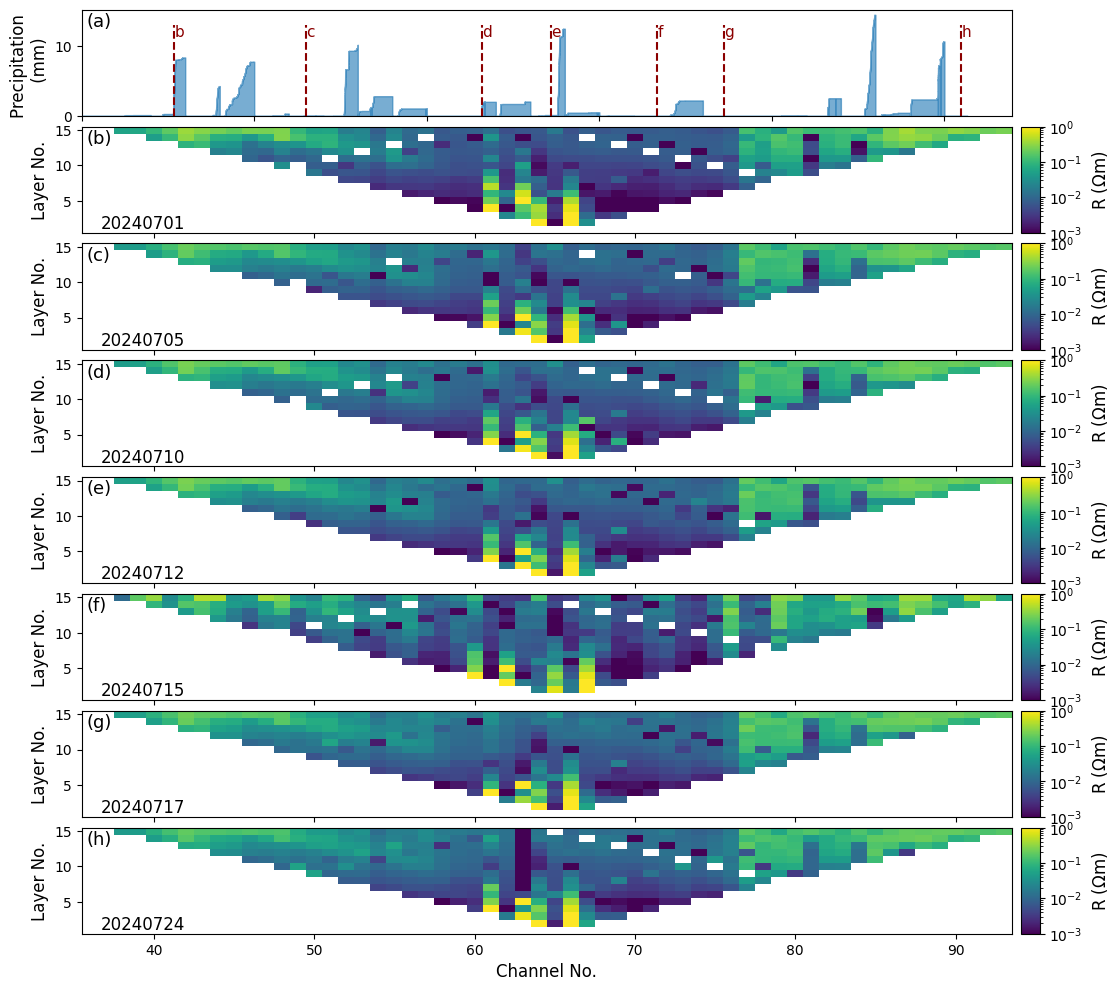

In [159]:
def __makeplot(imgs, norm=False):

    from matplotlib.colors import LogNorm

    Nrow, Ncol = len(imgs)+1, 1

    tscale = 1/86400

    font = 12

    lbl = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 12), sharex=False)

    plt.subplots_adjust(hspace=0.1)

    if norm:
        vmax = 1
    else:
        vmax = 1000

    # try:
    #     ax[2].plot(pegel.times_utc - ref_date, pegel.pegel, color="purple", alpha=0.9, zorder=3)
    # except:
    #     pass
    # ax[2].set_ylabel(f"Water Level (m)", fontsize=font, color="purple")
    # ax[2].set_zorder(3)
    # [t.set_color("purple") for t in ax[2].yaxis.get_ticklabels()]

    ax[0].fill_between(rain[0].times(reftime=t1)*tscale,
                       rain_data, color="tab:blue", alpha=0.6, label=f"rain", zorder=0)
    ax[0].set_ylabel(f"Precipitation \n (mm)", fontsize=font, color="k")

    ax[0].vlines(ctimes*tscale, 0, max(rain_data)*0.9, color="darkred", ls="--")

    for _x, _ll in zip(ctimes, lbl[1:]):
        ax[0].text(_x*tscale, max(rain_data)*0.9, _ll[1], ha="left", va="top", color="darkred", fontsize=font-1)

    ax[0].set_ylim(bottom=0)
    ax[0].set_xlim(left=0)


    for i, im in enumerate(imgs):

        j = i+1

        if norm:
            im_max = np.nanpercentile(abs(im.reshape(1, im.size)[0]), 99)
            print(im_max)
            im = im / im_max

        # _im = ax[j].pcolormesh(X, Y, im, cmap="viridis", vmax=vmax)
        _im = ax[j].pcolormesh(X, Y, im/vmax, cmap="viridis", norm=LogNorm(vmin=0.001, vmax=vmax))

        cax = ax[j].inset_axes([1.01, 0., 0.02, 1])
        cb = plt.colorbar(_im, cax, cax)
        cb.set_label("R ($\Omega$m)", fontsize=font, labelpad=5, color="k")

        ax[j].text(.02, .17, config['dates'][i], ha='left', va='top', transform=ax[j].transAxes, fontsize=font)
        ax[j].set_ylabel("Layer No.", fontsize=font)

    ax[Nrow-1].set_xlabel("Channel No.", fontsize=font)

    for _k, ll in enumerate(lbl):
        ax[_k].text(0.005, 0.97, ll, ha="left", va="top", transform=ax[_k].transAxes, fontsize=font+1)

    for n in range(Nrow-1):
        ax[n].set_xticklabels([])

    plt.show();
    return fig

fig = __makeplot(imgs, norm=True);

fig.savefig(config['path_to_figs']+f"RG_absolute.png", format="png", dpi=150, bbox_inches='tight')


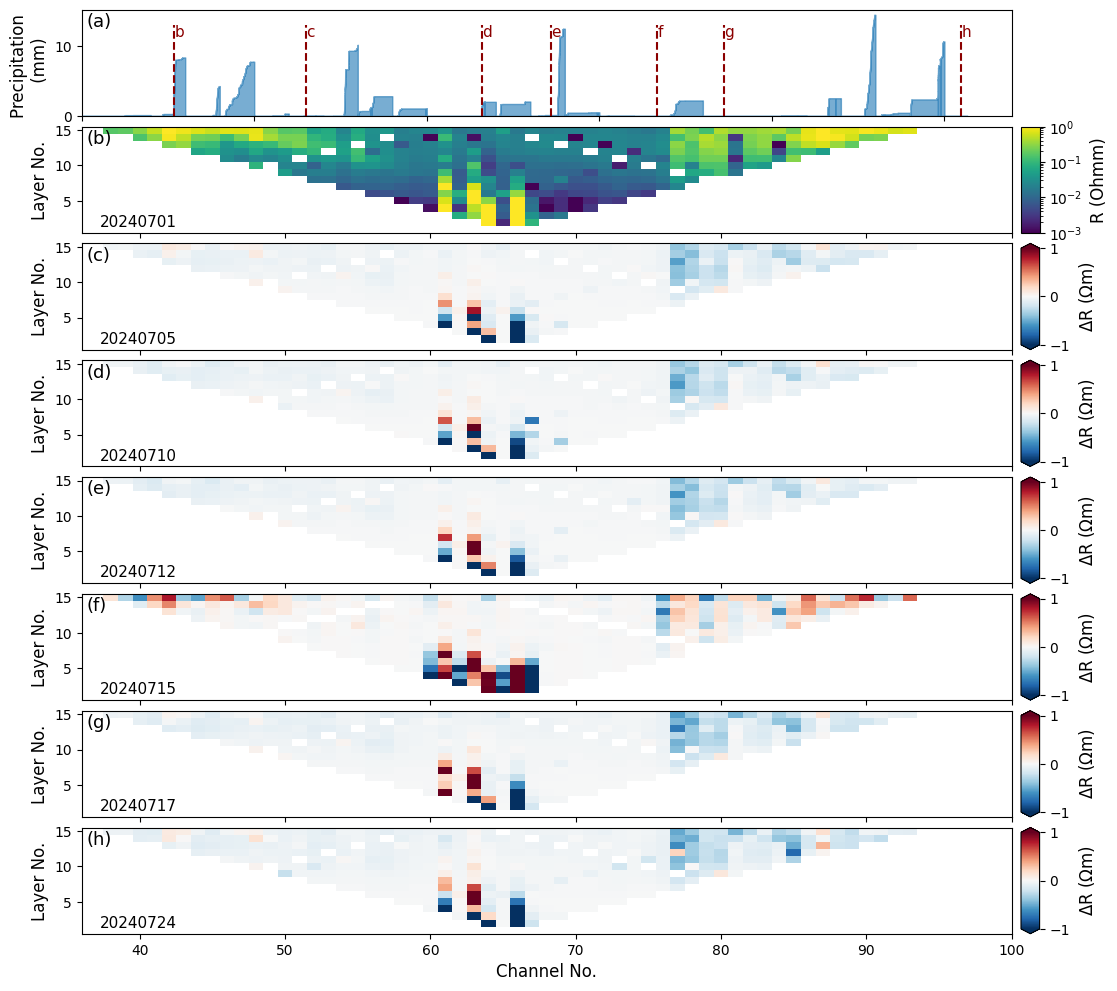

In [160]:
def __makeplot(imgs, norm=False):

    from matplotlib.colors import LogNorm

    Nrow, Ncol = len(imgs)+1, 1

    tscale = 1/86400

    font = 12

    lbl = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 12), sharex=False)

    plt.subplots_adjust(hspace=0.1)

    ax[0].fill_between(rain[0].times(reftime=t1)*tscale,
                       rain_data, color="tab:blue", alpha=0.6, label=f"rain", zorder=0)
    ax[0].set_ylabel(f"Precipitation \n (mm)", fontsize=font, color="k")

    ax[0].vlines(ctimes*tscale, 0, max(rain_data)*0.9, color="darkred", ls="--")

    for _x, _ll in zip(ctimes, lbl[1:]):
        ax[0].text(_x*tscale, max(rain_data)*0.9, _ll[1], ha="left", va="top", color="darkred", fontsize=font-1)

    ax[0].set_ylim(bottom=0)
    ax[0].set_xlim(left=0)


    vmax = 1000
    vlim = 300

    for i, im in enumerate(imgs):

        j = i + 1

        if norm:
            vmax = 1
            vlim = 1

            im_max = np.nanpercentile(abs(im.reshape(1, im.size)[0]), 97)
            im = im / im_max

        if i == 0:
            im0 = im

            if norm:
                _im = ax[j].pcolormesh(X, Y, im0, cmap="viridis", norm=LogNorm(vmin=0.001, vmax=vlim))
            else:
                _im = ax[j].pcolormesh(X, Y, im0, cmap="viridis", norm=LogNorm(vmin=0.1, vmax=vlim))

            cax = ax[j].inset_axes([1.01, 0., 0.02, 1])
            if norm:
                cb = plt.colorbar(_im, cax, cax)
            else:
                cb = plt.colorbar(_im, cax, cax, extend="both")
            cb.set_label("R (Ohmm)", fontsize=font, labelpad=5, color="k")

        else:
            _im = ax[j].pcolormesh(X, Y, im0-im, cmap="RdBu_r", vmin=-vlim, vmax=vlim)
            # _im = ax[j].imshow(abs(im0-im), cmap="viridis", norm=LogNorm(vmin=0.1, vmax=vlim))

            cax = ax[j].inset_axes([1.01, 0., 0.02, 1])
            cb = plt.colorbar(_im, cax=cax, extend="both")
            cb.set_label("$\Delta$R ($\Omega$m)", fontsize=font, labelpad=5, color="k")

        ax[j].text(.02, .17, config['dates'][i], ha='left', va='top', transform=ax[j].transAxes, fontsize=font-1)
        ax[j].set_xlim(left=36, right=100)
        ax[j].set_ylabel("Layer No.", fontsize=font)

    ax[Nrow-1].set_xlabel("Channel No.", fontsize=font)

    for _k, ll in enumerate(lbl):
        ax[_k].text(0.005, 0.97, ll, ha="left", va="top", transform=ax[_k].transAxes, fontsize=font+1)

    for n in range(Nrow-1):
        ax[n].set_xticklabels([])

    plt.show();
    return fig

fig = __makeplot(imgs, norm=True);

fig.savefig(config['path_to_figs']+f"RG_change.png", format="png", dpi=150, bbox_inches='tight')


## Test

In [12]:
date = config['dates'][1]

header = ["channel", "spacing_m", "layer", "R_ohmm", "I_mA", "U_muV", "XX"]

df0 = read_csv(config['path_to_data']+f"ROMY_{date}_new.csv", names=header)

df0

FileNotFoundError: [Errno 2] No such file or directory: '/import/kilauea-data/ROMY_geoelectric/data/ROMY_20240705_new.csv'

In [ ]:
max_layer = int(df0.layer.max())
min_channel = int(df0.channel.min())
max_channel = int(df0.channel.max())

img = np.ones((max_layer, max_channel))*np.nan

In [ ]:
value = "SD"

off = 0
for l in range(1, max_layer+1):
    for c in range(1, max_channel+1-off):
        _df = df0[(df0.layer == l) & (df0.channel == c)]
        if _df.empty:
            img[l-1, c-1+off] = np.nan
        else:
            # img[l-1, c-1] = _df.SD
            img[l-1, c-1+off] = _df[value]
    off += 0

In [ ]:
vmax = np.percentile(df0[value], 95)

plt.imshow(img, cmap="viridis", vmax=vmax)